In [34]:
import pandas as pd
import seaborn as sbn
import geopandas as geo_pd
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np
import sqlite3

## Load Unit Data

In [26]:
data_dir_prefix = '../../../../data/'

In [8]:
# query the unit response data for 2019
with sqlite3.connect(data_dir_prefix+'fire_data_v1.db') as db_conn:
    q = """
    SELECT 
        call_number, incident_number, call_type, call_type_group, 
        unit_id, unit_type, 
        call_date, received_dttm, dispatch_dttm, on_scene_dttm,
        `neighborhooods_-_analysis_boundaries`, case_location
    FROM calls_for_service 
    WHERE cast(strftime('%Y', received_dttm) as int) = 2019"""
    unit_response_data_raw = pd.read_sql_query(q, db_conn)

unit_response_data_raw.dtypes

call_number                              int64
incident_number                          int64
call_type                               object
call_type_group                         object
unit_id                                 object
unit_type                               object
call_date                               object
received_dttm                           object
dispatch_dttm                           object
on_scene_dttm                           object
neighborhooods_-_analysis_boundaries    object
case_location                           object
dtype: object

In [11]:
# convert dataframe to geodataframe
unit_response_data = geo_pd.GeoDataFrame(unit_response_data_raw)
unit_response_data['pt_case_location'] = geo_pd.GeoSeries.from_wkt(
    unit_response_data_raw['case_location'],
    crs='EPSG:4326')

unit_response_data = geo_pd.GeoDataFrame(unit_response_data, 
    geometry='pt_case_location')

unit_response_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 319855 entries, 0 to 319854
Data columns (total 13 columns):
 #   Column                                Non-Null Count   Dtype   
---  ------                                --------------   -----   
 0   call_number                           319855 non-null  int64   
 1   incident_number                       319855 non-null  int64   
 2   call_type                             319855 non-null  object  
 3   call_type_group                       317902 non-null  object  
 4   unit_id                               319855 non-null  object  
 5   unit_type                             319855 non-null  object  
 6   call_date                             319855 non-null  object  
 7   received_dttm                         319855 non-null  object  
 8   dispatch_dttm                         319855 non-null  object  
 9   on_scene_dttm                         259126 non-null  object  
 10  neighborhooods_-_analysis_boundaries  319855 non

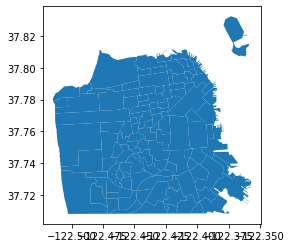

In [27]:
# grab the SF neighborhood map

sf_neighborhoods = geo_pd.read_file(data_dir_prefix+'raw/SF Find Neighborhoods.geojson')
_ = sf_neighborhoods.geometry.plot()

## Find Unit Service Areas

In [15]:
unit_response_data['unit_desc'] = unit_response_data['unit_type'] + '-' + unit_response_data['unit_id ']

In [25]:
# see if unit responses typically fit into a handful of neighborhoods
unit_response_data.groupby(['unit_desc', 'neighborhooods_-_analysis_boundaries'])\
    .agg({'incident_number':'count'}).unstack(fill_value=0.0)

incident_number                 \
neighborhooods_-_analysis_boundaries Bayview Hunters Point Bernal Heights   
unit_desc                                                                   
AIRPORT-AP                                             0.0            0.0   
CHIEF-B01                                              3.0            1.0   
CHIEF-B02                                              7.0            5.0   
CHIEF-B03                                             40.0           11.0   
CHIEF-B04                                              0.0            0.0   
...                                                    ...            ...   
TRUCK-T16                                              6.0            0.0   
TRUCK-T17                                           1014.0            7.0   
TRUCK-T18                                              1.0            0.0   
TRUCK-T19                                              0.0            1.0   
TRUCK-T48                                              1.0            0.0   

                                                                              \
neighborhooods_-_analysis_boundaries Castro/Upper Market Chinatown Excelsior   
unit_desc                                                                      
AIRPORT-AP                                           0.0       0.0       0.0   
CHIEF-B01                                            0.0     377.0       0.0   
CHIEF-B02                                          163.0       1.0       4.0   
CHIEF-B03                                            1.0      28.0       0.0   
CHIEF-B04                                            4.0      36.0       0.0   
...                                                  ...       ...       ...   
TRUCK-T16                                            0.0       0.0       0.0   
TRUCK-T17                                            0.0       0.0       5.0   
TRUCK-T18                                            1.0       0.0       0.0   
TRUCK-T19                                            0.0       0.0      16.0   
TRUCK-T48                                            0.0       0.0       0.0   

                                                                               \
neighborhooods_-_analysis_boundaries Financial District/South Beach Glen Park   
unit_desc                                                                       
AIRPORT-AP                                                      0.0       0.0   
CHIEF-B01                                                     797.0       0.0   
CHIEF-B02                                                      49.0       2.0   
CHIEF-B03                                                     946.0       0.0   
CHIEF-B04                                                      19.0       0.0   
...                                                             ...       ...   
TRUCK-T16                                                      32.0       0.0   
TRUCK-T17                                                       3.0       0.0   
TRUCK-T18                                                       0.0       0.0   
TRUCK-T19                                                       0.0       1.0   
TRUCK-T48                                                       7.0       0.0   

                                                                      \
neighborhooods_-_analysis_boundaries Golden Gate Park Haight Ashbury   
unit_desc                                                              
AIRPORT-AP                                        0.0            0.0   
CHIEF-B01                                         0.0            0.0   
CHIEF-B02                                         2.0           35.0   
CHIEF-B03                                         0.0            0.0   
CHIEF-B04                                         1.0            5.0   
...                                               ...            ...   
TRUCK-T16                                         1.0       

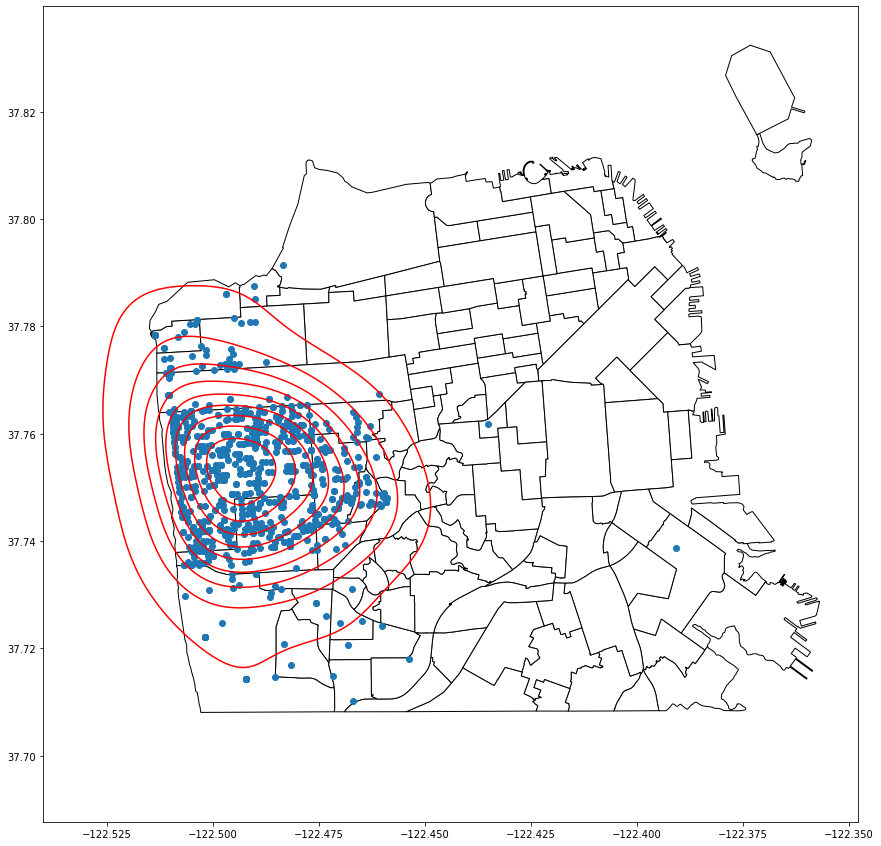

In [421]:
plt.rcParams["figure.figsize"]=15,15
selected_unit = 'TRUCK-T18'
selected_unit_data = unit_response_data.loc[unit_response_data['unit_desc'] == selected_unit]
unit_X = np.concatenate([
    selected_unit_data.geometry.x.to_numpy().reshape(-1, 1),
    selected_unit_data.geometry.y.to_numpy().reshape(-1, 1)], axis=1)

base_plot = sf_neighborhoods.plot(color='white', edgecolor='black')
_ = selected_unit_data.plot(ax=base_plot)
_ = sbn.kdeplot(x=unit_X[:,0], y=unit_X[:,1], ax=base_plot, colors="red", bw_adjust=2.0)


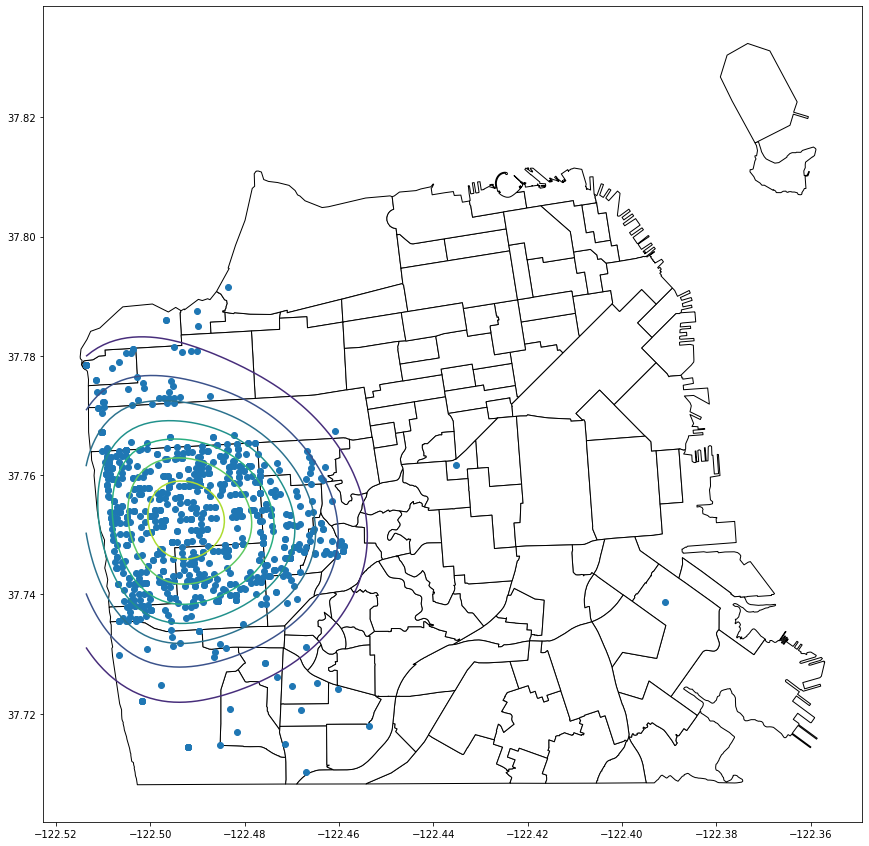

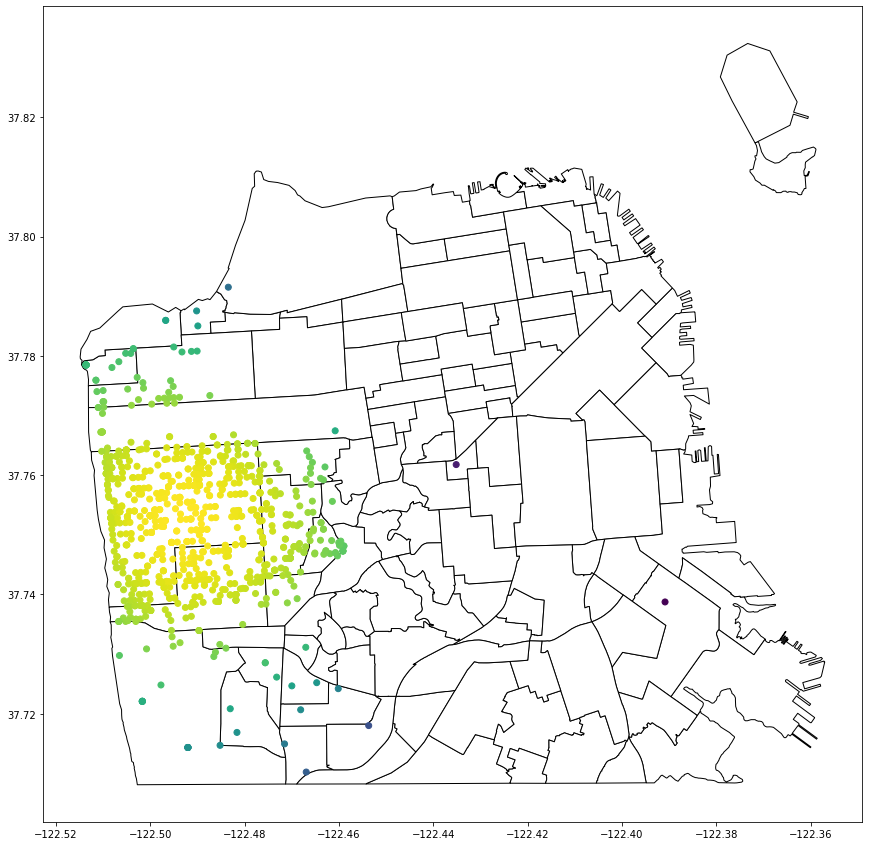

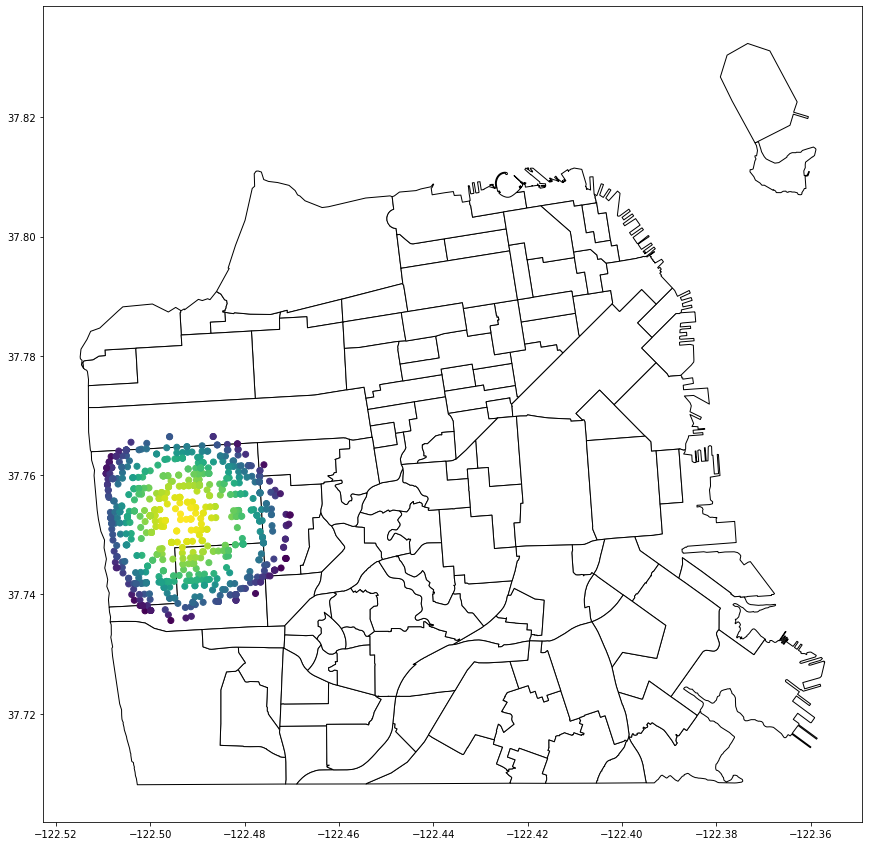

In [422]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

col_x = unit_X[:,0]
col_y = unit_X[:,1]

def kde2D(x, y, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    bandwidths = np.logspace(-2, -1, 10)
    kde_skl = KernelDensity(metric='haversine')
    grid = GridSearchCV(kde_skl,
                    {'bandwidth': bandwidths,
                     'kernel' : ["gaussian", "exponential", "linear",]})
    grid.fit(xy_train)

    kde_skl = KernelDensity(
        bandwidth=grid.best_params_["bandwidth"],
        kernel=grid.best_params_["kernel"],
        metric='haversine')
     
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    
    return kde_skl, xx, yy, np.reshape(z, xx.shape)

kde_est, xx, yy, zz = kde2D(col_x, col_y)

# plot countours
base_plot = sf_neighborhoods.plot(color='white', edgecolor='black')
_ = selected_unit_data.plot(ax=base_plot)
_ = plt.contour(xx, yy, zz)

# plot all points w/ heatmap
unit_scores = kde_est.score_samples(np.vstack([col_y, col_x]).T)
base_plot = sf_neighborhoods.plot(color='white', edgecolor='black')
_ = selected_unit_data.plot(ax=base_plot, c=unit_scores)

# plot filtered points w/ heatmap
unit_scores_df = pd.DataFrame({"unit_score":pd.Series(unit_scores)})
output = pd.concat([selected_unit_data.reset_index(drop=True), unit_scores_df.reset_index(drop=True)], axis=1)
output = output.loc[output.unit_score.quantile(0.25) < output.unit_score]
base_plot = sf_neighborhoods.plot(color='white', edgecolor='black')
_ = output.plot(ax=base_plot, c=output.unit_score)

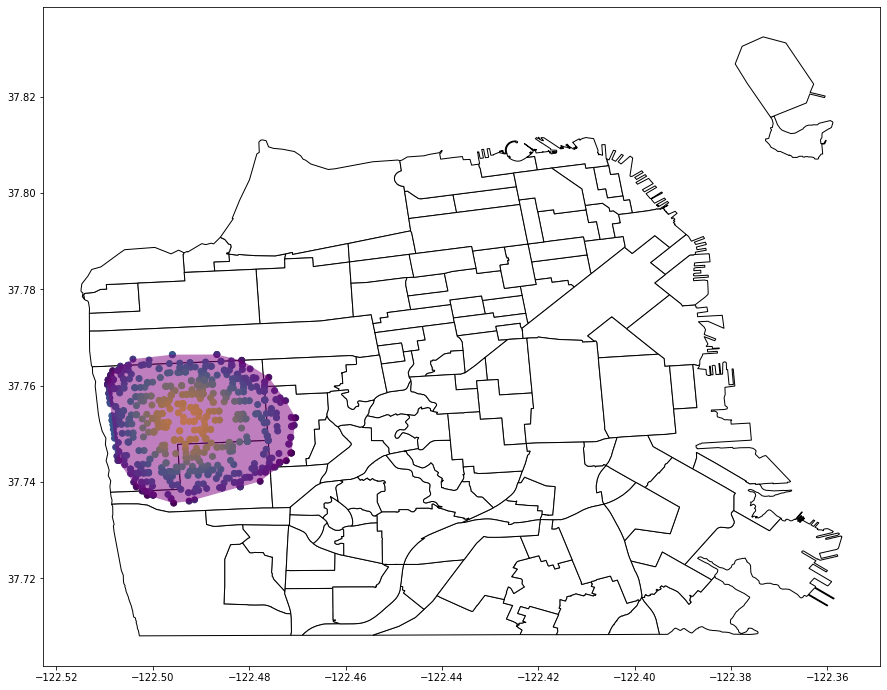

In [423]:
from shapely.geometry import Polygon, LineString, Point, MultiPoint
import shapely.wkt

bounding_box = MultiPoint([shapely.wkt.loads(p) for p in list(output.geometry.to_wkt())]).convex_hull

base_plot = sf_neighborhoods.plot(color='white', edgecolor='black')
_ = output.plot(ax=base_plot, c=output.unit_score)
_ = geo_pd.GeoSeries(bounding_box).plot(ax=base_plot, alpha=0.5, color='purple')
